In [1]:
from Pipeline import BLEPipeline, WifiPipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random, time
from imblearn.under_sampling import RandomUnderSampler
from itertools import izip, combinations

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Create dataset

In [2]:
time_start = time.time()

In [3]:
b = BLEPipeline()

In [4]:
# w.extract_packet_features(create_master=True)

In [5]:
df = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


## Resample

In [6]:
# Remove router device type and plug device type (not using plug because not enough devices)
df = df[(df["DeviceType"]!="router") & (df["DeviceType"]!="plug")]

df_train = df[df['Set']=='train']

### Downsampling

In [7]:
# List variables that do not work with resampling methods
dataframe_vars = {'Name', 'DeviceName', 'Set', 
                  'AccessAddr', 'AdvertAddr','PDUTypeNum'}
onehotEncoded_vars = {'ADV_DIRECT_IND', 'ADV_IND', 
                      'ADV_NONCONN_IND', 'ADV_SCAN_IND', 
                      'CONNECT_REQ', 'SCAN_REQ', 'SCAN_RSP'}
response_vars = {"DeviceType","door","lock","temp"}
ble_devicetypes = ["door","lock","temp"]

# Prep X, y
y = df_train["DeviceType"]
col_drop = response_vars | dataframe_vars | onehotEncoded_vars
X = df_train.drop(col_drop, axis=1)

In [8]:
rds = RandomUnderSampler()
X_downsampled, y_downsampled = rds.fit_resample(X, y)

In [9]:
# Recreate dataframe
X_downsampled = pd.DataFrame(data=X_downsampled, columns=X.columns)
y_downsampled = pd.DataFrame(data=y_downsampled, columns=['DeviceType'])

# Onehot encode 'DeviceType' in y_downsampled
y_downsampled = pd.concat([y_downsampled,pd.get_dummies(y_downsampled['DeviceType'])], axis=1)
y_downsampled = y_downsampled.drop(['DeviceType'],axis=1)

# Onehot categorical vars in X_downsampled
categorical_vars =['PDUType','RFChannel']
pdu_series = pd.get_dummies(X_downsampled['PDUType'])
rf_series = pd.get_dummies(X_downsampled['RFChannel'])
X_downsampled = pd.concat([X_downsampled, pdu_series, rf_series], axis=1)
X_downsampled = X_downsampled.drop(categorical_vars,axis=1)

# # Combine X and y into one dataframe
df_train_downsampled = pd.concat([X_downsampled, y_downsampled], axis=1)

### Plots

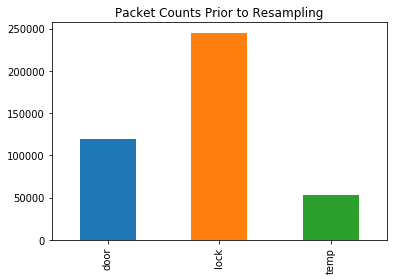

In [10]:
# Resample packets based on DeviceType
# Useful info used from https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets#
devtype_df = df["DeviceType"].value_counts().sort_index()
devtype_df.plot(kind='bar', title="Packet Counts Prior to Resampling");

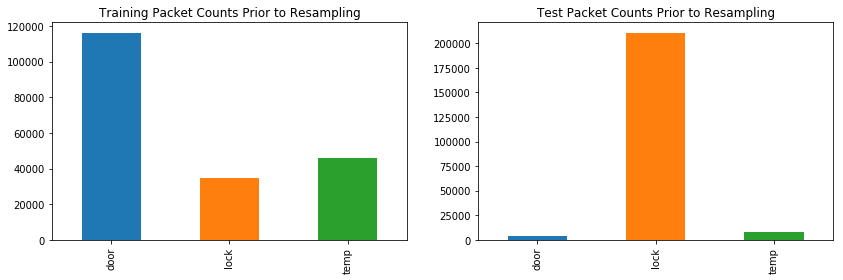

In [11]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train = df[df["Set"]=="train"]
plt.subplot(1, 2, 1)
df_train["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts Prior to Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts Prior to Resampling");


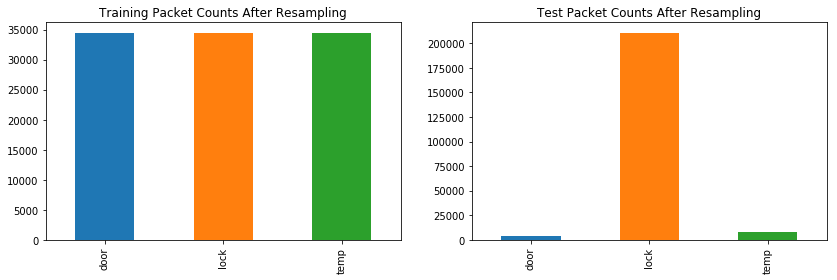

In [12]:
plt.subplots(1, 2, figsize=(14,4)) # number of rows, number of columns, figure size=(width, height)

# Plot training set
df_train_downsampled['DeviceType'] = df_train_downsampled[ble_devicetypes].idxmax(1)
plt.subplot(1, 2, 1)
df_train_downsampled['DeviceType'].value_counts().sort_index().plot(kind='bar', title="Training Packet Counts After Resampling");

# Plot test set
df_test = df[df["Set"]=="test"]
plt.subplot(1, 2, 2)
df_test["DeviceType"].value_counts().sort_index().plot(kind='bar', title="Test Packet Counts After Resampling");


# Run All vs One classification

In [14]:
# Reinsert Set column to training dataset
df_train_downsampled['Set'] = 'train'

# Onehot encode 'RFChannel' in test set
rf_series = pd.get_dummies(df_test["RFChannel"])
df_test = pd.concat([df_test, rf_series], axis=1)

# Ensure same number of columns in both training and test datasets
train_cols = df_train_downsampled.columns
df_test_samecols = df_test[train_cols]

# Combine training and test sets into one dataframe
df_downsampled = pd.concat([df_train_downsampled,df_test_samecols],axis=0)

In [15]:
one_under_devtype = b.one_vs_one_classify(df_downsampled, X_downsampled.columns, y_downsampled.columns)

Device Pair: ('door', 'lock')
--------------------------
--------------------------
RF Confusion Matrix
Predicted    door  lock
Actual                 
door         3587     0
lock       207342  3302 

RF Metrics
          FN      FP    TN    TP  Accuracy  Precision    Recall
door       0  207342  3302  3587  0.032157   0.017006  1.000000
lock  207342       0  3587  3302  0.032157   1.000000  0.015676 

--------------------------
KNN Confusion Matrix
Predicted    door   lock
Actual                  
door         3301    286
lock       189361  21283 

KNN Metrics
          FN      FP     TN     TP  Accuracy  Precision    Recall
door     286  189361  21283   3301  0.114755   0.017134  0.920268
lock  189361     286   3301  21283  0.114755   0.986740  0.101038 

--------------------------
LDA Confusion Matrix
Predicted    door  lock
Actual                 
door            1  3586
lock       210639     5 

LDA Metrics
          FN      FP  TN  TP  Accuracy  Precision    Recall
door    3586 

In [16]:
all_over_device = b.one_vs_all_classify(df_downsampled, X_downsampled.columns, y_downsampled.columns)

Device Type: door
RF

Confusion Matrix
Predicted    door  rest
Actual                 
door          137  3450
rest       210931  7411

Metrics
          FN      FP    TN    TP  Accuracy  Precision    Recall
door    3450  210931  7411   137  0.034011   0.000649  0.038193
rest  210931    3450   137  7411  0.034011   0.682350  0.033942
---------------------------------------------------------
KNN

Confusion Matrix
Predicted    door   rest
Actual                  
door          785   2802
rest       190766  27576

Metrics
          FN      FP     TN     TP  Accuracy  Precision    Recall
door    2802  190766  27576    785  0.127793   0.004098  0.218846
rest  190766    2802    785  27576  0.127793   0.907762  0.126297
---------------------------------------------------------
LDA

Confusion Matrix
Predicted    door  rest
Actual                 
door           14  3573
rest       210662  7680

Metrics
          FN      FP    TN    TP  Accuracy  Precision    Recall
door    3573  210662  7680  

## Reports

### Confusion Matrix

In [19]:
# Extract confusion matrices
classifiers = ['KNN', 'LDA', 'RF']
device_cms = []
for device in sorted(ble_devicetypes):
    classifier_cms = []
    for classifier in sorted(classifiers):
        classifier_cms.append(all_over_device[0][device][classifier]['CM'])
    device_cms.append(classifier_cms)


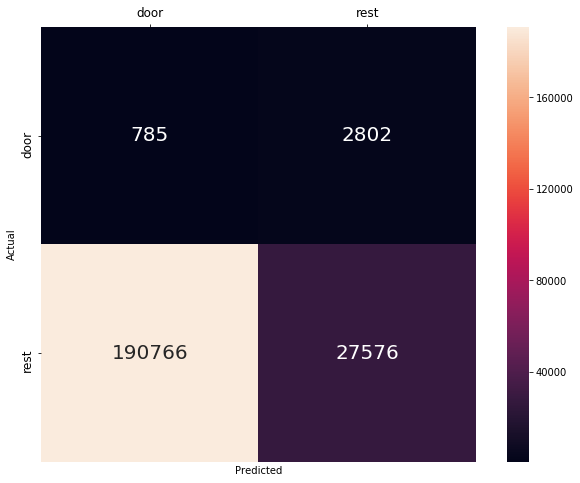

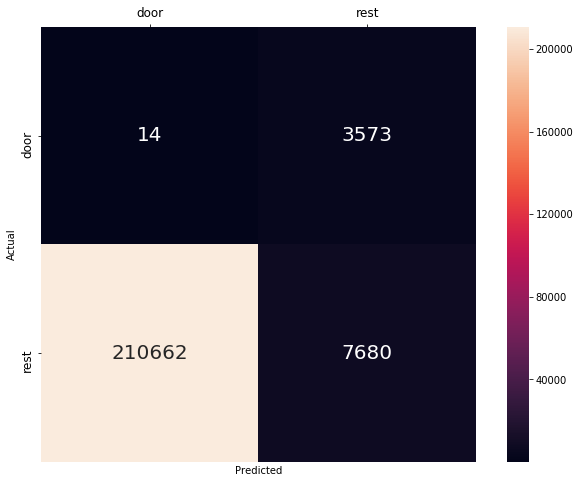

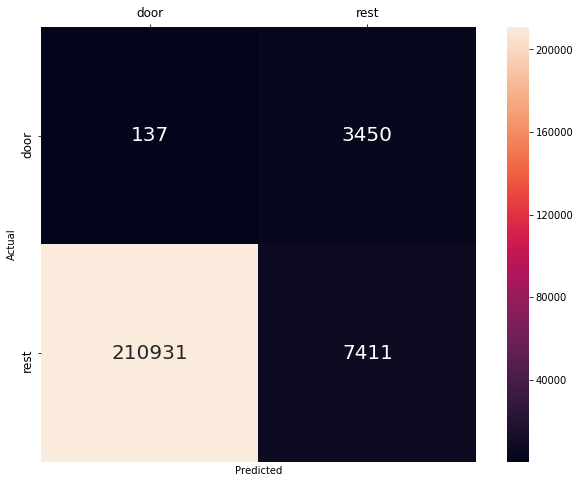

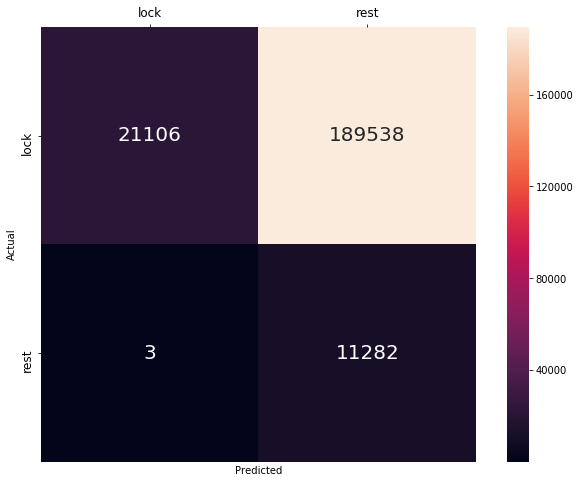

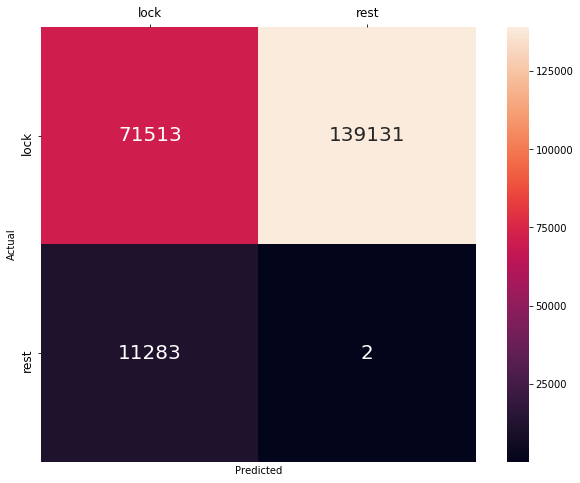

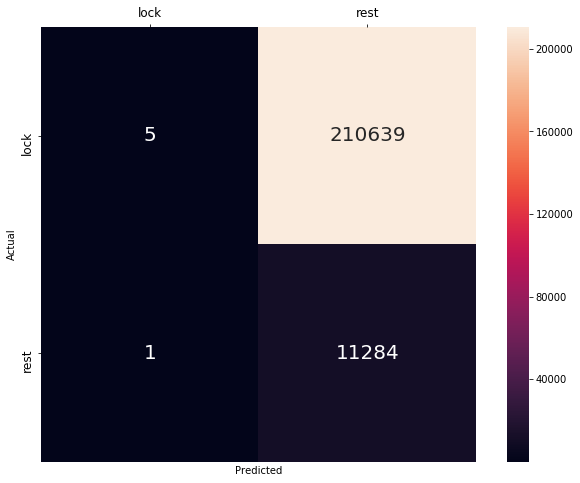

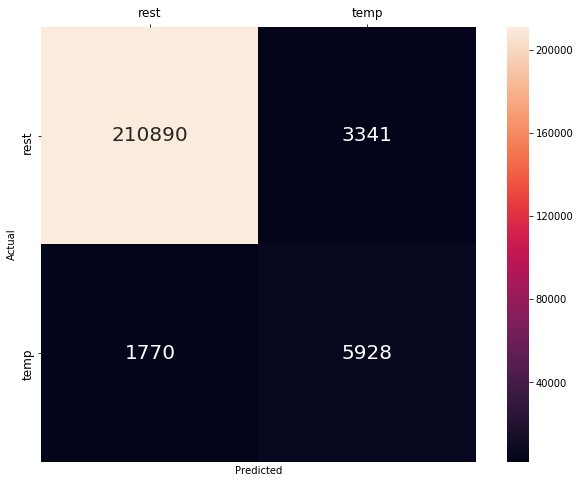

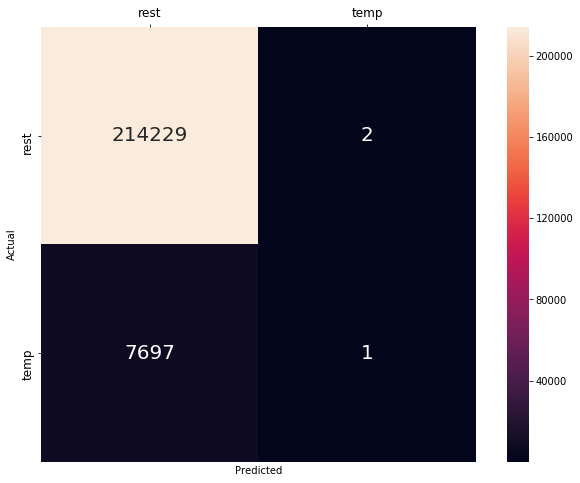

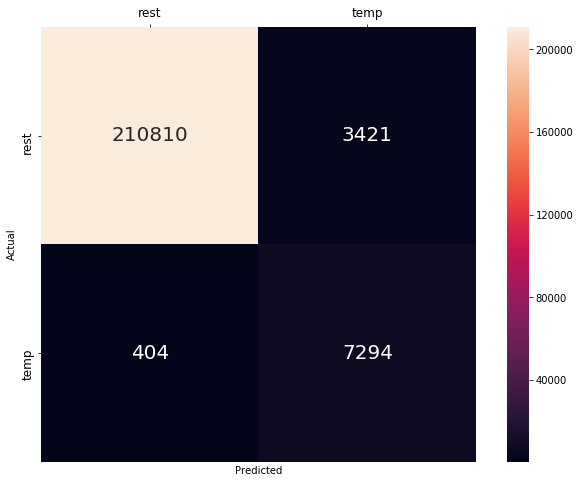

In [26]:
for device_list in device_cms:
    for classifier_cm in device_list:
        fig, ax = plt.subplots(figsize=(11,8))
        ax.tick_params(labelsize='large')
        ax.xaxis.set_ticks_position('top')
        sns.heatmap(classifier_cm, annot=True, annot_kws={"size":20},square=True, fmt='d');

### Accuracy, Precision, Recall

In [24]:
# Extract metrics
device_metrics = []
for device in sorted(ble_devicetypes):
    classifier_metrics = []
    for classifier in sorted(classifiers):
        classifier_metrics.append(all_over_device[0][device][classifier]['Metrics'][['Accuracy','Precision','Recall']].loc[device])
    device_metrics.append(classifier_metrics)


In [25]:
for device_list in device_metrics:
    for classifier_metrics, c in zip(device_list, classifiers):
        print c
        print classifier_metrics, "\n"

KNN
Accuracy     0.127793
Precision    0.004098
Recall       0.218846
Name: door, dtype: float64 

LDA
Accuracy     0.034669
Precision    0.000066
Recall       0.003903
Name: door, dtype: float64 

RF
Accuracy     0.034011
Precision    0.000649
Recall       0.038193
Name: door, dtype: float64 

KNN
Accuracy     0.145939
Precision    0.999858
Recall       0.100197
Name: lock, dtype: float64 

LDA
Accuracy     0.322243
Precision    0.863725
Recall       0.339497
Name: lock, dtype: float64 

RF
Accuracy     0.050868
Precision    0.833333
Recall       0.000024
Name: lock, dtype: float64 

KNN
Accuracy     0.976970
Precision    0.639551
Recall       0.770070
Name: temp, dtype: float64 

LDA
Accuracy     0.965309
Precision    0.333333
Recall       0.000130
Name: temp, dtype: float64 

RF
Accuracy     0.982765
Precision    0.680728
Recall       0.947519
Name: temp, dtype: float64 



### AUC